# FPDP implementation

The goal of FPDP is to analyze model fairness by fixing the value of a specific feature (like Car price) and checking how the model's predictions vary across a protected group (like Age_Group). In here, we are comparing these predictions using statistical tests (Chi-Square) to check if there's significant unfairness across different feature values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Replace 'your_file.csv' with the name of your CSV file
df = pd.read_csv('C:\\Users\\yacco\\afi_project_1\\afi_final_project\\predictions_output_gradient_boosting.csv')

# Display the first few rows of the data
df.head()

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Group,Predicted_PD,True_Label
0,2,22,8900,8900,0,60,0.084828,0,0,0,0,0.268061,1
1,0,55,10400,9400,0,72,0.083889,0,0,0,0,0.350588,0
2,1,40,15990,14990,0,60,0.127142,0,1,0,0,0.204690,1
3,5,43,19999,23233,0,72,0.153289,0,0,0,0,0.391570,0
4,1,26,11800,4298,1,24,0.115528,0,0,0,0,0.109665,0


Here, we have the dataset with the features, 

In [2]:
df_true = df.drop(columns=['Predicted_PD', 'Group'])

In [3]:
df_true

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,True_Label
0,2,22,8900,8900,0,60,0.084828,0,0,0,1
1,0,55,10400,9400,0,72,0.083889,0,0,0,0
2,1,40,15990,14990,0,60,0.127142,0,1,0,1
3,5,43,19999,23233,0,72,0.153289,0,0,0,0
4,1,26,11800,4298,1,24,0.115528,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2224,13,72,13170,7170,0,48,0.045833,0,1,1,0
2225,12,60,2900,3135,0,36,0.065714,0,0,0,0
2226,0,32,14900,10900,0,48,0.164167,0,0,0,0
2227,0,63,14990,13990,0,84,0.062667,0,1,1,0


In [4]:
from sklearn.model_selection import train_test_split

X = df_true.drop('True_Label', axis=1)
y = df_true['True_Label']

# Assuming X is your feature set and y is your target variable (e.g., binary outcome)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

# Recreate the best Gradient Boosting model
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

best_gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42, subsample=0.8)

In [6]:
X_test

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner
56,2,67,8980,8980,0,60,0.046154,0,0,1
494,11,38,15340,11340,0,36,0.159454,0,0,0
1671,17,38,13000,13000,0,48,0.114384,1,0,0
218,2,26,10360,10490,0,60,0.063889,0,0,0
952,28,60,13209,13209,0,72,0.176667,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1811,0,32,6600,6600,0,60,0.088953,0,0,0
2015,16,47,19300,16300,0,60,0.074306,0,1,1
1133,10,40,8475,9652,0,60,0.092432,0,1,0
1481,23,45,11850,9704,0,48,0.063984,0,1,1


In [7]:
# This statistical parity formula determines the predicted default rate for both Group 0 and Group 1,
# and the difference between the predicted PD's would then be determined if statistically significant
# through a Chi Square test.

# We divide our feature set into continous/discrete. The reason is that for continuous features we will divide the data into
# bins while for discrete features we will take all values

continuous_features = ['Car price', 'Funding amount', 'Monthly payment']
discrete_features = ['Job tenure', 'Loan duration', 'Married', 'Homeowner']

# Function to perform Chi-Square test for fairness
# Age group (< or > 45) is used as a discriminant. What this function does is that, for each iteration of the estimator, 
# it computes the predictions, then builds a contingency table based on Age group and the predictions results for 
# each age group. Then we compute the p-val from the chi2 test to estimate fairness.

def chi_square_test(variable, predictions):
    contingency_table = pd.crosstab(variable, predictions, colnames=["Predictions"])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_value, dof, expected, contingency_table

# function to compute_bins. if the feature is discrete, simply all values of the feature are returned.
def compute_bins(feature, is_continuous):
    if is_continuous:
        return pd.cut(X[feature], bins=5).unique()
    else:
        return X[feature].unique() # return all values if the feature is discrete (like marriage or homeowner)


Feature: Car price, Feature Value: 4537.8895
Contingency Table:
Predictions    0    1
Age_Group            
0             56  148
1            120  122
P-Value: 3.047466146473148e-06


Feature: Car price, Feature Value: 12241.3
Contingency Table:
Predictions    0   1
Age_Group           
0            141  63
1            227  15
P-Value: 1.927570768289562e-11


Feature: Car price, Feature Value: 19925.5
Contingency Table:
Predictions    0   1
Age_Group           
0            185  19
1            241   1
P-Value: 1.7467864253639897e-05


Feature: Car price, Feature Value: 27609.699999999997
Contingency Table:
Predictions    0   1
Age_Group           
0            185  19
1            241   1
P-Value: 1.7467864253639897e-05


Feature: Car price, Feature Value: 35293.9
Contingency Table:
Predictions    0   1
Age_Group           
0            192  12
1            242   0
P-Value: 0.00041388650423846844


Feature: Funding amount, Feature Value: 3627.8625
Contingency Table:
Predictions    


Feature: Married, Feature Value: 0
Contingency Table:
Predictions    0   1
Age_Group           
0            165  39
1            241   1
P-Value: 1.8065911724562496e-11


Feature: Married, Feature Value: 1
Contingency Table:
Predictions    0   1
Age_Group           
0            166  38
1            242   0
P-Value: 7.409563766977433e-12


Feature: Homeowner, Feature Value: 0
Contingency Table:
Predictions    0   1
Age_Group           
0            165  39
1            239   3
P-Value: 3.442989960411963e-10


Feature: Homeowner, Feature Value: 1
Contingency Table:
Predictions    0   1
Age_Group           
0            176  28
1            242   0
P-Value: 8.547789721330479e-09



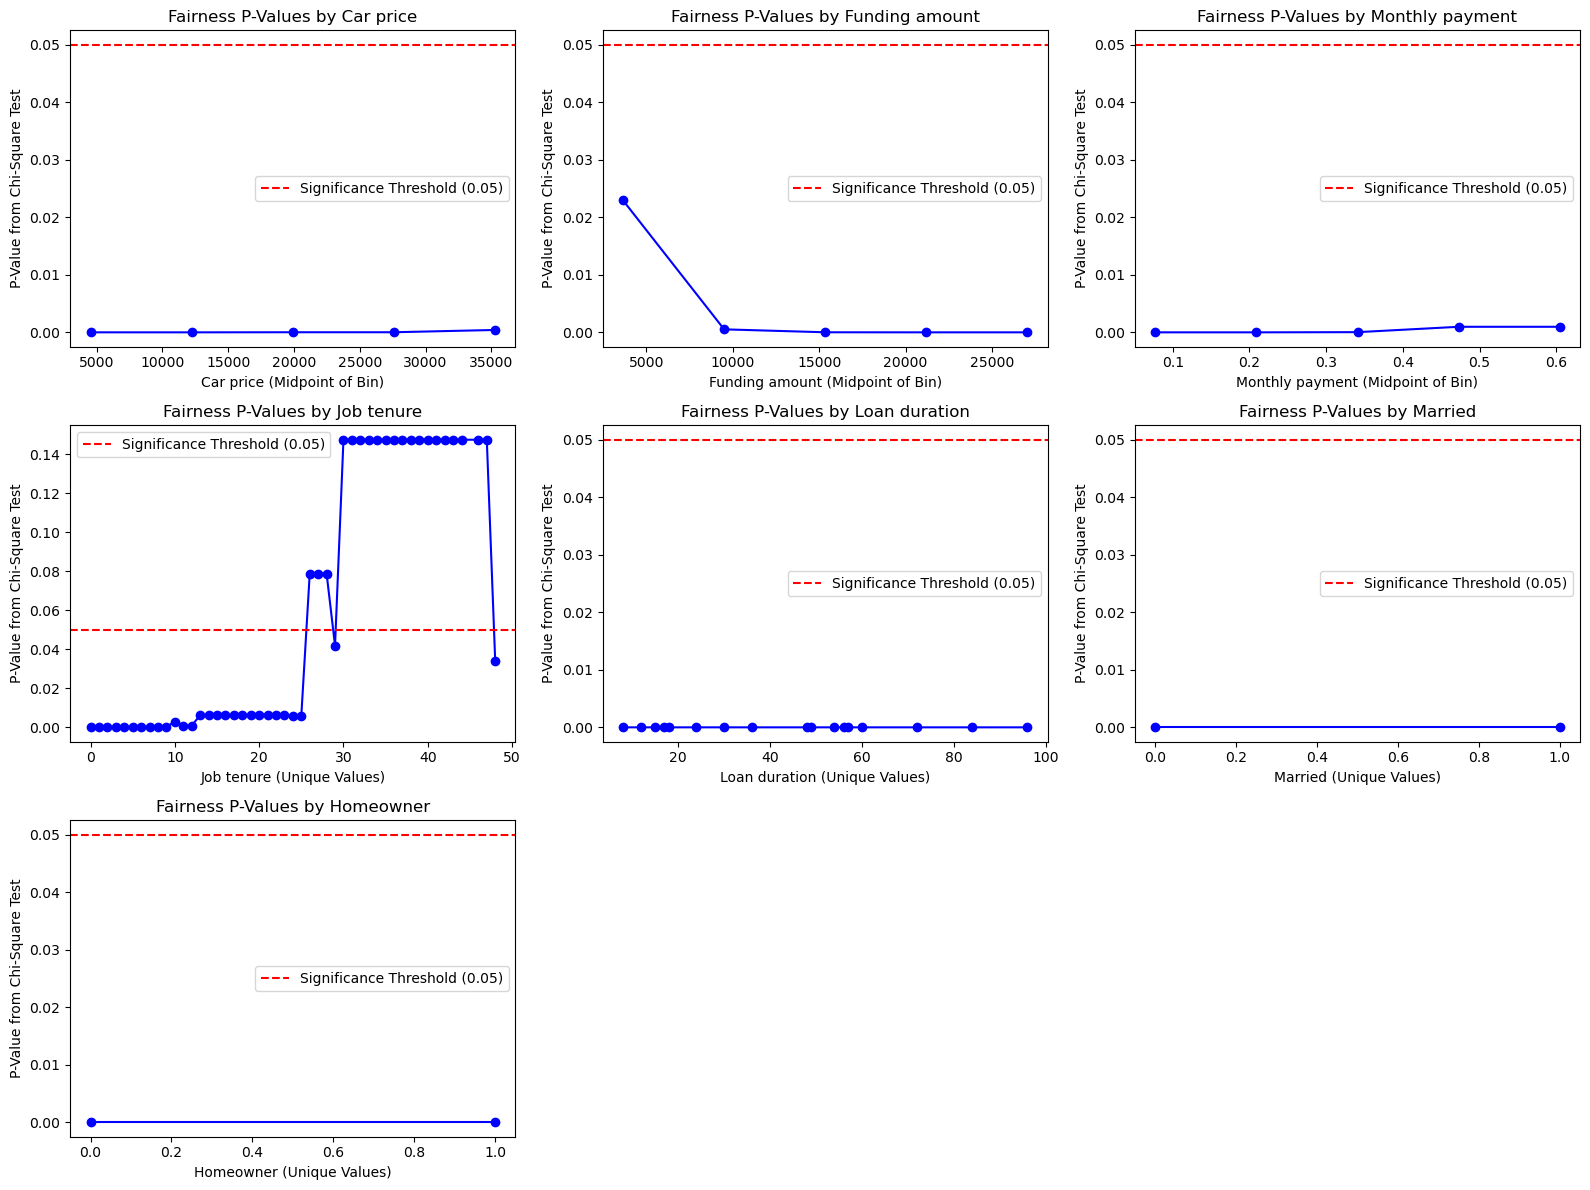

In [19]:
from sklearn.preprocessing import LabelEncoder
import math
le = LabelEncoder()

# Combine the continuous and discrete feature lists into one loop
features = continuous_features + discrete_features

# Number of features
num_features = len(features)

# Define the number of rows and columns (3 columns)
num_columns = 3
num_rows = math.ceil(num_features / num_columns)  # Calculate the required number of rows

# Create subplots grid (3 columns, num_rows rows)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, num_rows * 4))

# Flatten axes in case we have a grid
axes = axes.flatten()

# Iterate over each feature to compute p-values and plot
for i, feature in enumerate(features):
    bin_midpoints_pvalues = []
    
    # Check if the feature is continuous
    is_continuous = feature in continuous_features
    
    # Compute bins (for continuous features) or take all unique values (for discrete features)
    bin_vals = compute_bins(feature, is_continuous)
    
    # Iterate over each bin or unique value and fix the feature to that value
    for bin_val in bin_vals:
        if is_continuous:
            # For continuous features, calculate the midpoint of the bin
            midpoint = (bin_val.left + bin_val.right) / 2
            feature_value = midpoint
        else:
            # For discrete features, use the unique value directly
            feature_value = bin_val
        
        # fix the feature's value
        X_temp = X_test.copy()
        X_temp[feature] = feature_value
        
        # Predict binary outcomes using the OPTIMAL black box model
        predictions = best_gb_model.predict(X_temp)
        
        X_temp['Age_Group'] = pd.cut(X_test['Age'], bins=[0, 45, 100], labels=['Age < 45', 'Age ≥ 45'])
        X_temp['Age_Group'] = le.fit_transform(X_temp['Age_Group'])        
        
        # Perform Chi-Square test for fairness
        chi2_stat, p_value, dof, expected, contingency_table = chi_square_test(X_temp['Age_Group'], predictions)
        
        # Store the (feature value, p-value, contingency table) pair
        bin_midpoints_pvalues.append((feature_value, p_value, contingency_table))
    
    # Sort the list based on the feature values 
    bin_midpoints_pvalues.sort(key=lambda x: x[0])  # Sort by the first element (feature value)
    
    # Print the contingency table and p-value in the correct sorted order
    for feature_value, p_value, contingency_table in bin_midpoints_pvalues:
        print(f"\nFeature: {feature}, Feature Value: {feature_value}")
        print("Contingency Table:")
        print(contingency_table)
        print(f"P-Value: {p_value}\n")
    
    # Separate ONLY the bin_midpoints and p_values to plot them
    bin_midpoints, p_values = zip(*[(x[0], x[1]) for x in bin_midpoints_pvalues])
    
     # Plot FPDP for the current feature
    axes[i].plot(bin_midpoints, p_values, marker='o', linestyle='-', color='b')
    axes[i].axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
    axes[i].set_xlabel(f'{feature} (Midpoint of Bin)' if is_continuous else f'{feature} (Unique Values)')
    axes[i].set_ylabel('P-Value from Chi-Square Test')
    axes[i].set_title(f'Fairness P-Values by {feature}')
    axes[i].legend()
    
# Remove any empty subplots (if any)
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])    

plt.tight_layout()
plt.show()